In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# Transforms pour ResNet
transform_resnet = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset
from google.colab import drive
drive.mount('/content/drive')

# Unzip les dataset dans /tmp
!unzip -q "/content/drive/MyDrive/IA201/plant.zip" -d "/tmp/plant"

Tesla T4
Mounted at /content/drive


In [3]:
# Script to split the dataset into training and testing sets
import os
import glob
import shutil
import numpy as np

train_path = '/tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
new_train_path = '/tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train'
new_test_path = new_train_path.replace('train', 'test')

subfolders = [ f.path for f in os.scandir(train_path) if f.is_dir() ]
test_percent = 0.2

for folder in sorted(subfolders):

    # For each subfolder, create a dictionary with the key as the image name
    # and the value as a list of all the filenames that contain that key
    filenames = sorted(glob.glob(os.path.join(folder, '*')))
    if 'Corn_(maize)___Common_rust_' in folder:
        keys = [f.split('/')[-1][:12] for f in filenames]
    else:
        keys = [f.split('/')[-1].split('_')[0] for f in filenames]
    keys = np.unique(keys)

    image_dict = {}

    # Create a dictionary with the key as the image name and the value as a list of all the filenames that contain that key
    for key in keys:
        image_dict[key] = []
        for filename in filenames:
            if key in filename:
                image_dict[key].append(filename)

    n_images = len(keys)
    print(f'There are {len(keys)} unique images in the folder {folder}')

    n_train = int(n_images * (1 - test_percent))
    n_test = n_images - n_train

    idx = np.arange(n_images)
    np.random.shuffle(idx)
    train_idx = idx[:n_train]
    test_idx = idx[n_train:]

    # Create the train and test folders
    train_folder = os.path.join(new_train_path, os.path.basename(folder))
    test_folder = os.path.join(new_test_path, os.path.basename(folder))
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    print(f'Creating {train_folder} and {test_folder}')
    # Copy the files to the train and test folders
    for i in train_idx:
        for filename in image_dict[keys[i]]:
            shutil.copy(filename, train_folder)
    for i in test_idx:
        for filename in image_dict[keys[i]]:
            shutil.copy(filename, test_folder)

# Copy the validation folder
# shutil.copytree('plants-disease-dataset/valid', 'new-plants-disease-dataset/valid')


old_train_filenames = sorted(glob.glob(os.path.join(train_path, '*/*')))
train_filenames = sorted(glob.glob(os.path.join(new_train_path, '*/*')))
test_filenames = sorted(glob.glob(os.path.join(new_test_path, '*/*')))

print('Before: train images:', len(old_train_filenames))
print('After: train images:', len(train_filenames))
print('After: test images:', len(test_filenames))

if len(old_train_filenames) != len(train_filenames) + len(test_filenames):
    print('Error: the number of images in the old train folder is not equal to the sum of the new train and test folders')
else:
    print('Success: the number of images in the old train folder is equal to the sum of the new train and test folders')

There are 630 unique images in the folder /tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab
Creating /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train/Apple___Apple_scab and /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/test/Apple___Apple_scab
There are 619 unique images in the folder /tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot
Creating /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train/Apple___Black_rot and /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/test/Apple___Black_rot
There are 275 unique images in the folder /tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust
Creating /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train/Apple___Cedar_apple_rust and /tmp/plant/New Plant Diseases Dataset(Augmented

In [4]:
train_dataset = ImageFolder("/tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train", transform=transform_resnet)
valid_dataset = ImageFolder("/tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid", transform=transform_resnet)
test_dataset = ImageFolder("/tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/test", transform=transform_resnet)

BATCH_SIZE = 128
NUM_WORKERS = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# MODELE AVEC FEATURE EXTRACTION
def get_frozen_resnet18():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 38)
    )
    return model.to(device)

# MODELE AVEC FINE-TUNING
def get_finetuned_resnet18():
    model = models.resnet18(pretrained=True)
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 38)
    )
    return model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
# Choix du modèle :
model = get_finetuned_resnet18()  # ou get_frozen_resnet18()

# Optimizer et loss
trainable_params = filter(lambda p: p.requires_grad, model.parameters()) # Choix des param en fonction du modele

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(trainable_params, lr=0.0005, betas=(0.9, 0.999))

# Entraînement
model.train()

loss_list = []
loss_list_idx = []
acc_list = []
val_acc_list = []
val_loss_list = []

compteur = 0

for epoch in range(15):
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()

    model.train()  # Mode entraînement

    for i, (inputs, labels) in enumerate(train_loader):
        if i % 50 == 0:
            batch_start = time.time()

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Prédictions pour accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            print(f"Batch {i} time: {time.time() - batch_start:.2f}s")
            loss_list.append(running_loss / 50)
            loss_list_idx.append(compteur * 50)
            running_loss = 0.0
            compteur += 1

    # Accuracy à la fin de l’époque
    epoch_acc = 100 * correct / total
    acc_list.append(epoch_acc)
    print(f'→ Accuracy après epoch {epoch + 1}: {epoch_acc:.2f}%')
    print(f"Epoch time: {time.time() - start:.2f}s")

    # Phase de validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in valid_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(valid_loader)

    val_acc_list.append(val_acc)
    val_loss_list.append(avg_val_loss)

    print(f'→ Validation accuracy: {val_acc:.2f}% | Validation loss: {avg_val_loss:.4f}')

print('Finished Training')

# Affichage des courbes
# Train
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_list_idx, loss_list)
plt.title("Loss function")
plt.xlabel("Minibatch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc_list) + 1), acc_list, marker='o')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

# Val
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_list)//len(train_loader)+1), [np.mean(loss_list[i::len(train_loader)]) for i in range(len(train_loader))], label='Train Loss')
plt.plot(range(1, len(val_loss_list)+1), val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss par epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc_list)+1), acc_list, label='Train Accuracy')
plt.plot(range(1, len(val_acc_list)+1), val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy par epoch")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


[1,    50] loss: 1.519
Batch 49 time: 12.07s
[1,   100] loss: 0.356
Batch 99 time: 12.71s
[1,   150] loss: 0.259
Batch 149 time: 12.54s
[1,   200] loss: 0.239
Batch 199 time: 13.07s
[1,   250] loss: 0.199
Batch 249 time: 12.32s
[1,   300] loss: 0.174
Batch 299 time: 12.24s
[1,   350] loss: 0.172
Batch 349 time: 11.58s
[1,   400] loss: 0.139
Batch 399 time: 12.19s
→ Accuracy après epoch 1: 90.67%
Epoch time: 109.82s
→ Validation accuracy: 96.28% | Validation loss: 0.1197
[2,    50] loss: 0.133
Batch 49 time: 11.94s
[2,   100] loss: 0.122
Batch 99 time: 12.27s
[2,   150] loss: 0.107
Batch 149 time: 12.29s
[2,   200] loss: 0.102
Batch 199 time: 12.92s
[2,   250] loss: 0.115
Batch 249 time: 12.30s
[2,   300] loss: 0.110
Batch 299 time: 11.87s
[2,   350] loss: 0.096
Batch 349 time: 9.80s
[2,   400] loss: 0.098
Batch 399 time: 12.78s
→ Accuracy après epoch 2: 96.85%
Epoch time: 107.57s
→ Validation accuracy: 96.96% | Validation loss: 0.0964
[3,    50] loss: 0.100
Batch 49 time: 12.27s
[3,   

KeyboardInterrupt: 

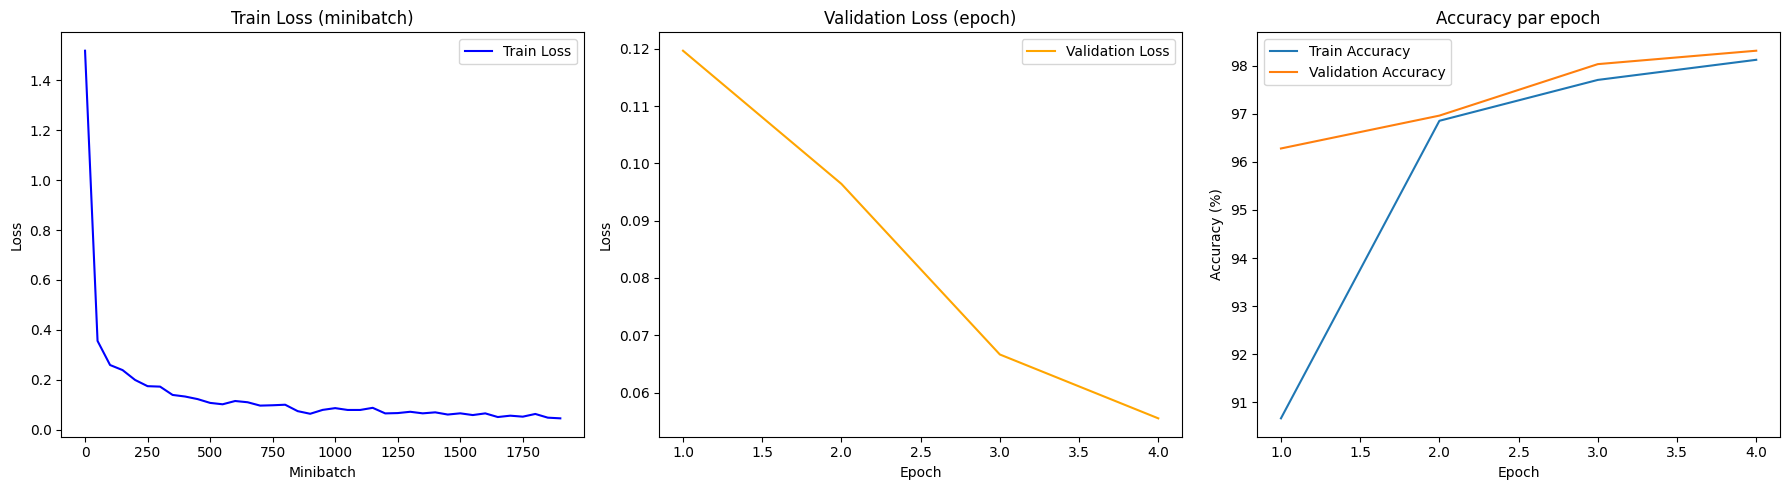

Accuracy on test set: 97.47%


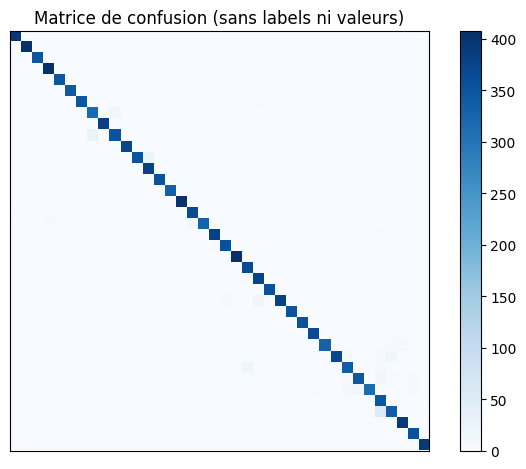

In [6]:
plt.figure(figsize=(18, 5))  # Largeur augmentée pour 3 sous-graphes

# 1. Train Loss
plt.subplot(1, 3, 1)
plt.plot(loss_list_idx, loss_list, color='blue', label='Train Loss')
plt.title("Train Loss (minibatch)")
plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.legend()

# 2. Validation Loss par epoch
plt.subplot(1, 3, 2)
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, color='orange', label='Validation Loss')
plt.title("Validation Loss (epoch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 3. Accuracy pour Train et Validation
plt.subplot(1, 3, 3)
plt.plot(range(1, len(acc_list) + 1), acc_list, label='Train Accuracy')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Accuracy')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy globale
print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Affichage sans labels ni valeurs
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, include_values=False)

# Supprimer les ticks et les labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

plt.title("Matrice de confusion (sans labels ni valeurs)")
plt.tight_layout()
plt.show()